In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize
from scipy.special import expit as sigmoid
from pathlib import Path
import seaborn as sns

COMP_NAME = "g2net-gravitational-wave-detection"
INPUT_PATH = f"../input/{COMP_NAME}/"
OUTPUT_PATH = f"../input/ensemble-0916/"

In [2]:
gt = pd.read_csv(INPUT_PATH + "/" + "training_labels.csv")
names = ["A-RN200","A-B5PL","A-B5","A-V2M","A-1D","A-CWT","A-B3","A-B3CWT",
       "I-B3","I-B4","I-B5","I-B7","I-IV3",
       "R-1D","R-V2SD","R-V2SD2","R-V2","R-V2SDCBAM","R-133",#"R-137",
       "V-V2SD","V_3D",
       "M-1D", "M-1DS32","M-1DC16","M-SD16","M-SD32",
      ]

model_names = ["resnet-200d","eff-B5","eff-b5","ef-v2M","1dCNN","CWT","B3","B3CWT"]
oof_files = [
    "oofs_20210830-191530_CV-0.87733.csv", # ResNet200d
    "oofs_20210918-112751_CV-0.87870.csv", # EfficientNet B5
    "oofs_20210901-130913_CV-0.87749.csv", # EfficientNet B5
    "oofs_20210902-200442_CV-0.87733.csv", # EfficientNet V2 M
    "oofs_20210915-003751_CV-0.87393.csv", # 1D CNN
    "oofs_20210915-072731_CV-0.87707.csv",  # CWT
    "oofs_20210923-103832_CV-0.87829.csv",  # B3
    "oofs_20210925-085935_CV-0.87818.csv",  # B3-CWT
]

oof_paths = [OUTPUT_PATH + "/" + (model_names[i] + "-" + f.split("_")[1]+"_predictions") + "/" + f for i,f in enumerate(oof_files)]
sub_paths = [OUTPUT_PATH  + "/" + (model_names[i] + "-" + f.split("_")[1]+"_predictions") + "/" + f.replace("oofs", "sub") for i,f in enumerate(oof_files)]
#test_paths = [OUTPUT_PATH / (model_names[i] + "-" + f.split("_")[1]+"_predictions") / f.replace("oofs", "test") for i,f in enumerate(oof_files)]

oof_paths_other = [
    OUTPUT_PATH + '/oof_effB3-512-PL-float.csv', 
    OUTPUT_PATH + '/oof_effB4-512-PL-CV087755.csv', 
    OUTPUT_PATH + '/oof_effB5-512-PL-CV087728.csv', 
    OUTPUT_PATH + '/oof_w_effB7-512-SKF.csv', 
    OUTPUT_PATH +  "/oof_inception_v3_PL_CV087466.csv",        
    OUTPUT_PATH +  "/oof_1DCNN_richard.csv",
    OUTPUT_PATH +  "/oof_112nd_V2SD_PL.csv",    
    OUTPUT_PATH + "/oof_121st_V2SD.csv",
    OUTPUT_PATH + "/oof_122nd_V2.csv",
    OUTPUT_PATH + "/oof_124th_V2SDCBAM_tta_blend.csv",
    OUTPUT_PATH + "/oof_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv",    
    #OUTPUT_PATH + "/oof_137th_tta_blend.csv",    
    #OUTPUT_PATH +  "/oof_V2_c16_sGW_vflip_sc01_PL_CV88163.csv",        
    OUTPUT_PATH +  "/oof_V2SD_sGW_vflip_sc01_PL_CV88003.csv",        
    #OUTPUT_PATH +  "/oof_resnet34-sGW2ep-PL-sc01_CV87764.csv",   
    OUTPUT_PATH +  "/oof_1D2D_1ep_CV88153.csv",   
    OUTPUT_PATH +  "/oof_1D_adjust_MC_CV88158.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_Split32_MC_CV88149.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_c16_MC_CV88170.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_SD16_MC_CV88164.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_SD32_MC_CV88185.csv",  
    
    
    
    
]

sub_paths_other = [
    OUTPUT_PATH + '/submission_effB3-512-PL-CV0877245.csv', 
    OUTPUT_PATH + '/submission_effB4-512-PL-CV087755.csv' ,
    OUTPUT_PATH + '/submission_effB5-512-PL-CV087728.csv', 
    OUTPUT_PATH + '/submission_w_effB7-512-SKF.csv', 
    OUTPUT_PATH +  "/submission_inception_v3_PL_CV087466.csv",        
    OUTPUT_PATH + '/submission_main_35th_GeM_vflip_shuffle01.csv',
    OUTPUT_PATH +  "/submission_112nd_V2SD_PL.csv",
    OUTPUT_PATH + "/submission_121st_V2SD.csv",
    OUTPUT_PATH + "/submission_122nd_V2.csv",
    OUTPUT_PATH + "/submission_124th_V2SDCBAM_tta_blend.csv",
    OUTPUT_PATH + "/submission_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv",    
    #OUTPUT_PATH + "/submission_137th_tta_blend.csv",    
    #OUTPUT_PATH +  "/submission_V2_c16_sGW_vflip_sc01_PL_CV88163.csv",        
    OUTPUT_PATH +  "/submission_V2SD_sGW_vflip_sc01_PL_CV88003.csv",        
    #OUTPUT_PATH +  "/submission_resnet34-sGW2ep-PL-sc01_CV87764.csv",    
    OUTPUT_PATH +  "/submission_1D2D_1ep_CV88153.csv",   
    OUTPUT_PATH +  "/submission_1D_adjust_MC_CV88158.csv",       
    OUTPUT_PATH +  "/submission_1D_adjust_Split32_MC_CV88149.csv",       
    OUTPUT_PATH +  "/submission_1D_adjust_c16_MC_CV88170.csv",  
    OUTPUT_PATH +  "/submission_1D_adjust_SD16_MC_CV88164.csv",  
    OUTPUT_PATH +  "/submission_1D_adjust_SD32_MC_CV88185.csv",  
]

oof_paths.extend(oof_paths_other)
sub_paths.extend(sub_paths_other)

oof_list = [pd.read_csv(p) for p in oof_paths]
sub_list = [pd.read_csv(p) for p in sub_paths]
#test_list = [pd.read_csv(p) for p in test_paths]

oof1 = oof_list[0]
sub1 = sub_list[0]
#test1 = test_list[0]

oof_df = oof1[["id", "target", "fold"]].copy()
for i, oof in enumerate(oof_list):
    if "effB" in oof_paths[i] or 'inception_v3' in oof_paths[i]:
        # oof from Isamu
        oof_df = oof_df.merge(oof[["id","y_pred"]].rename(columns={"y_pred":names[i]}),on=["id"], how='left')
    else:
        oof_df = oof_df.merge(oof[["id","prediction"]].rename(columns={"prediction":names[i]}),on=["id"], how='left')
        
sub_df = sub1[["id"]].copy()
for i, sub in enumerate(sub_list):
    sub_df = sub_df.merge(sub[["id","target"]].rename(columns={"target":names[i]}),on=["id"], how='left')
print("Finish Loading Data")

Finish Loading Data


In [3]:
oof_df.isna().sum(axis=0)

id            0
target        0
fold          0
A-RN200       0
A-B5PL        0
A-B5          0
A-V2M         0
A-1D          0
A-CWT         0
A-B3          0
A-B3CWT       0
I-B3          0
I-B4          0
I-B5          0
I-B7          0
I-IV3         0
R-1D          0
R-V2SD        0
R-V2SD2       0
R-V2          0
R-V2SDCBAM    0
R-133         0
V-V2SD        0
V_3D          0
M-1D          0
M-1DS32       0
M-1DC16       0
M-SD16        0
M-SD32        0
dtype: int64

In [4]:
{names[i]: ".".join(path.split("/")[-1].split(".")[:-1]) for i, path in enumerate(oof_paths)}

{'A-RN200': 'oofs_20210830-191530_CV-0.87733',
 'A-B5PL': 'oofs_20210918-112751_CV-0.87870',
 'A-B5': 'oofs_20210901-130913_CV-0.87749',
 'A-V2M': 'oofs_20210902-200442_CV-0.87733',
 'A-1D': 'oofs_20210915-003751_CV-0.87393',
 'A-CWT': 'oofs_20210915-072731_CV-0.87707',
 'A-B3': 'oofs_20210923-103832_CV-0.87829',
 'A-B3CWT': 'oofs_20210925-085935_CV-0.87818',
 'I-B3': 'oof_effB3-512-PL-float',
 'I-B4': 'oof_effB4-512-PL-CV087755',
 'I-B5': 'oof_effB5-512-PL-CV087728',
 'I-B7': 'oof_w_effB7-512-SKF',
 'I-IV3': 'oof_inception_v3_PL_CV087466',
 'R-1D': 'oof_1DCNN_richard',
 'R-V2SD': 'oof_112nd_V2SD_PL',
 'R-V2SD2': 'oof_121st_V2SD',
 'R-V2': 'oof_122nd_V2',
 'R-V2SDCBAM': 'oof_124th_V2SDCBAM_tta_blend',
 'R-133': 'oof_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05',
 'V-V2SD': 'oof_V2SD_sGW_vflip_sc01_PL_CV88003',
 'V_3D': 'oof_1D2D_1ep_CV88153',
 'M-1D': 'oof_1D_adjust_MC_CV88158',
 'M-1DS32': 'oof_1D_adjust_Split32_MC_CV88149',
 'M-1DC16': 'oof_1D_adjust_c16_MC_CV88170',
 'M-SD16': 'oof_

In [5]:
oof_df.shape

(560000, 29)

In [6]:
oof_df.head()

,id,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00000e74ad,1,3,-0.351255,-0.522575,-0.033018,-0.152198,-0.841736,-0.347086,-0.208484,...,0.307355,0.427559,0.255428,0.360444,0.373976,0.360875,0.371726,0.336293,0.327337,0.298945
1,00001f4945,0,0,-0.803476,-1.338088,-1.106954,-0.725166,-1.709305,-1.180710,-1.225705,...,0.101910,0.112691,0.104326,0.118170,0.099576,0.106059,0.123024,0.099103,0.114302,0.099525
2,0000661522,0,4,-1.121866,-1.507696,-1.106752,-1.140151,-1.570441,-1.062900,-1.160880,...,0.161061,0.192216,0.188557,0.198105,0.129473,0.204139,0.126147,0.166569,0.159226,0.199106
3,00007a006a,0,0,-1.295713,-1.526156,-1.164980,-1.197089,-1.090511,-1.212057,-1.370953,...,0.101480,0.102064,0.130833,0.135400,0.117951,0.155885,0.153501,0.127285,0.136019,0.114051
4,0000a38978,1,4,-0.233715,-0.393928,-0.257395,0.126759,-1.130708,-0.315936,-0.620537,...,0.246235,0.303882,0.268977,0.290217,0.250171,0.284270,0.259535,0.230736,0.349107,0.457787


In [7]:
sub_df.head()

,id,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,I-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00005bced6,2.101307,2.408690,2.269970,2.290631,3.007926,2.265291,2.288800,2.101119,0.998701,...,0.999747,0.999962,0.999971,0.999833,0.999944,0.999543,0.999769,0.999699,0.999302,0.998848
1,0000806717,1.514980,1.710782,1.526297,1.593227,1.630305,1.380817,1.237861,0.926948,0.903440,...,0.915381,0.956749,0.907443,0.909374,0.951770,0.957589,0.965001,0.951319,0.949645,0.924419
2,0000ef4fe1,-0.669418,-0.838041,-0.598816,-0.475593,-0.898371,-0.664295,-0.820795,-1.002344,0.229692,...,0.232941,0.244787,0.239195,0.305708,0.219522,0.251602,0.262339,0.262544,0.298552,0.287797
3,00020de251,1.280244,1.573700,1.490624,1.264398,1.089086,1.525732,0.952786,1.033834,0.761568,...,0.937249,0.979087,0.928078,0.853633,0.908216,0.964059,0.979279,0.959553,0.967139,0.951196
4,00024887b5,-1.376278,-1.757232,-1.403377,-1.430901,-2.033942,-1.442704,-1.653411,-1.793073,0.158145,...,0.053091,0.050590,0.061209,0.086943,0.064644,0.076858,0.068511,0.077224,0.099398,0.086851


In [8]:
oof_df.describe()

,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
count,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,...,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000
mean,0.499875,2.000000,0.046828,-0.058198,0.106662,0.101230,0.036813,0.065030,-0.119318,-0.238042,...,0.446232,0.453965,0.450615,0.467862,0.452312,0.460126,0.481366,0.487934,0.505703,0.489330
std,0.500000,1.414215,1.481512,1.726563,1.685370,1.497658,2.043871,1.502482,3.167510,1.583683,...,0.385009,0.386274,0.381813,0.360484,0.379084,0.379492,0.363063,0.358679,0.348692,0.350731
min,0.000000,0.000000,-2.612311,-2.920961,-36.039394,-2.466414,-3.281515,-2.409353,-2.730645,-2.763245,...,0.009655,0.009439,0.016804,0.018401,0.014317,0.016653,0.013040,0.019282,0.027650,0.028851
25%,0.000000,1.000000,-1.148762,-1.457553,-1.134825,-1.116461,-1.618619,-1.129007,-1.415669,-1.473963,...,0.103551,0.106535,0.110501,0.152991,0.117002,0.128182,0.169842,0.182117,0.201784,0.192716
50%,0.000000,2.000000,-0.542804,-0.758978,-0.505731,-0.501343,-0.796667,-0.525964,-0.773762,-0.847536,...,0.262015,0.272559,0.268920,0.319863,0.276226,0.270287,0.292222,0.298627,0.335655,0.302295
75%,1.000000,3.000000,1.659993,1.922530,1.795110,1.860344,1.987943,1.790570,1.564970,1.447580,...,0.969253,0.980589,0.971551,0.938428,0.967296,0.982787,0.991222,0.991854,0.989942,0.983396
max,1.000000,4.000000,7.474235,109.516266,241.051575,26.659441,5.508315,42.650219,590.999146,68.140289,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
sub_df.describe()

,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,I-B3,I-B4,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
count,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,...,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000
mean,-0.013878,-0.130381,0.044970,0.039600,-0.046625,0.004683,-0.189549,-0.306090,0.473161,0.487229,...,0.429710,0.448581,0.433880,0.452480,0.435771,0.443270,0.465290,0.472138,0.490581,0.474341
std,1.453328,1.667306,1.573125,1.467607,2.005636,1.455384,2.160146,1.507303,0.343080,0.338824,...,0.379178,0.381243,0.375714,0.353681,0.374158,0.374207,0.357628,0.353460,0.342611,0.342324
min,-2.485015,-2.579532,-2.308764,-2.208016,-3.021012,-2.192105,-2.490708,-2.585276,0.052723,0.055773,...,0.011923,0.011414,0.016183,0.023444,0.015365,0.019546,0.030344,0.041206,0.052687,0.049810
25%,-1.165660,-1.475116,-1.154036,-1.132633,-1.633426,-1.142866,-1.437398,-1.493855,0.185519,0.199050,...,0.101785,0.109355,0.109335,0.151680,0.113506,0.125228,0.167230,0.179526,0.200057,0.191329
50%,-0.599527,-0.831122,-0.573852,-0.558589,-0.872813,-0.587209,-0.857699,-0.915538,0.309953,0.334033,...,0.243203,0.271034,0.249772,0.302380,0.256699,0.252404,0.277704,0.283967,0.322215,0.297375
75%,1.512126,1.759078,1.674070,1.621865,1.652125,1.551509,1.339853,1.223311,0.925433,0.935325,...,0.931051,0.966499,0.931465,0.876134,0.930001,0.960864,0.968134,0.974700,0.963867,0.935114
max,7.742320,31.386963,65.547010,16.921555,5.073774,20.982845,139.015530,20.821293,0.999209,0.999533,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


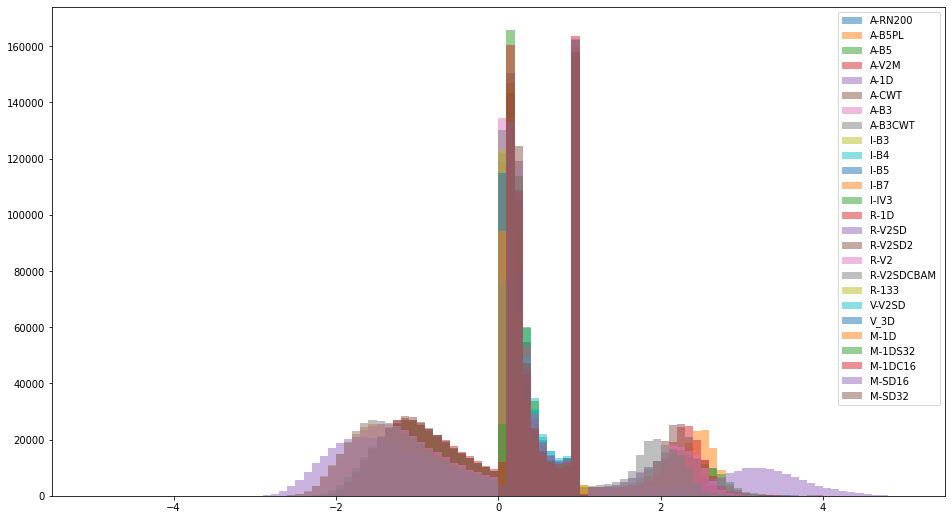

In [10]:
plt.figure(figsize=(16,9))
for o in oof_df.columns[3:]:
    plt.hist(oof_df[o], bins=100, alpha=0.5, range=[-5, 5], label=o)
plt.legend(loc='upper right');

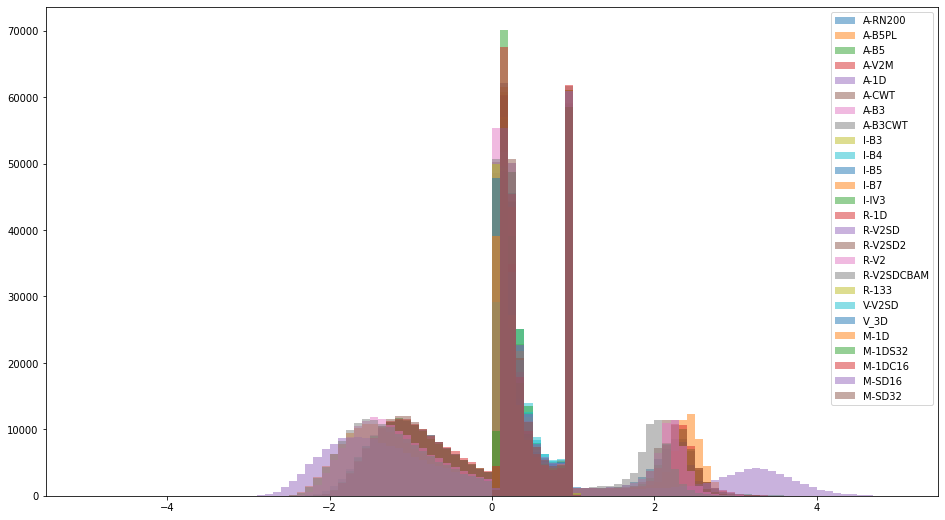

In [11]:
plt.figure(figsize=(16,9))
for s in sub_df.columns[1:]:
    plt.hist(sub_df[s], bins=100, alpha=0.5, range=[-5, 5], label=s)
plt.legend(loc='upper right');

In [12]:
def score_oof(oof, full=False, col=None):
    if col is None:
        col = "prediction"
    if full:
        return round(roc_auc_score(oof["target"], oof[col]),6)
    else:
        scores = [roc_auc_score(df["target"], df[col]) for _, df in oof.groupby("fold")]
        return round(np.mean(scores),6)

In [13]:
for i, col in enumerate(oof_df.columns[3:]):
    print(col," : ",score_oof(oof_df, col=col), score_oof(oof_df, col=col, full=True))

A-RN200  :  0.877332 0.877133
A-B5PL  :  0.878699 0.878355
A-B5  :  0.877494 0.876022
A-V2M  :  0.877331 0.877244
A-1D  :  0.873926 0.873418
A-CWT  :  0.877065 0.876578
A-B3  :  0.878287 0.87651
A-B3CWT  :  0.878179 0.877968
I-B3  :  0.877313 0.877245
I-B4  :  0.877582 0.877555
I-B5  :  0.877439 0.877278
I-B7  :  0.876767 0.876656
I-IV3  :  0.876062 0.874668
R-1D  :  0.877578 0.877473
R-V2SD  :  0.880986 0.880142
R-V2SD2  :  0.88098 0.880661
R-V2  :  0.880932 0.880418
R-V2SDCBAM  :  0.881243 0.879949
R-133  :  0.881255 0.880026
V-V2SD  :  0.88003 0.878623
V_3D  :  0.881525 0.881471
M-1D  :  0.881582 0.881369
M-1DS32  :  0.881491 0.881375
M-1DC16  :  0.881703 0.881631
M-SD16  :  0.881637 0.880418
M-SD32  :  0.881853 0.879239


In [14]:
pre_method = "logit"
clip = 20
eps = 1e-9
for i, col in enumerate(oof_df.columns[3:]):
    if pre_method == 'rank':
        oof_df[col] = oof_df[col].rank(pct=True)
        sub_df[col] = sub_df[col].rank(pct=True)
    if pre_method == 'rank-fold':
        oof_df[col] = oof_df.groupby('fold')[col].rank(pct=True)
        sub_df[col] = sub_df[col].rank(pct=True)
    elif pre_method == 'logit':
        if oof_df[col].max() > 1:
            oof_df[col] = np.clip(oof_df[col], -clip, clip)
            sub_df[col] = np.clip(sub_df[col], -clip, clip)
            pass
        else:
            oof_df[col] =  np.log(oof_df[col]) - np.log(1-oof_df[col]+eps)
            sub_df[col] = np.log(sub_df[col]) - np.log(1-sub_df[col]+eps)
    elif pre_method == "prob":
        if oof_df[col].max() <= 1 and oof_df[col].min() >= 0:
            continue
        else:
            oof_df[col] = np.exp(oof_df[col]) / (1 + np.exp(oof_df[col]))
            sub_df[col] = np.exp(sub_df[col]) / (1 + np.exp(sub_df[col]))
    elif pre_method == "prob**2":
        if oof_df[col].max() <= 1 and oof_df[col].min() >= 0:
            oof_df[col] = oof_df[col] ** 2
            sub_df[col] = sub_df[col] ** 2
        else:
            oof_df[col] = (np.exp(oof_df[col]) / (1 + np.exp(oof_df[col]))) ** 2
            sub_df[col] = (np.exp(sub_df[col]) / (1 + np.exp(sub_df[col]))) ** 2

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
if pre_method == "rank-fold":
    for i, col in enumerate(oof_df.columns[3:]):
        print(col," : ",score_oof(oof_df, col=col), score_oof(oof_df, col=col, full=True))

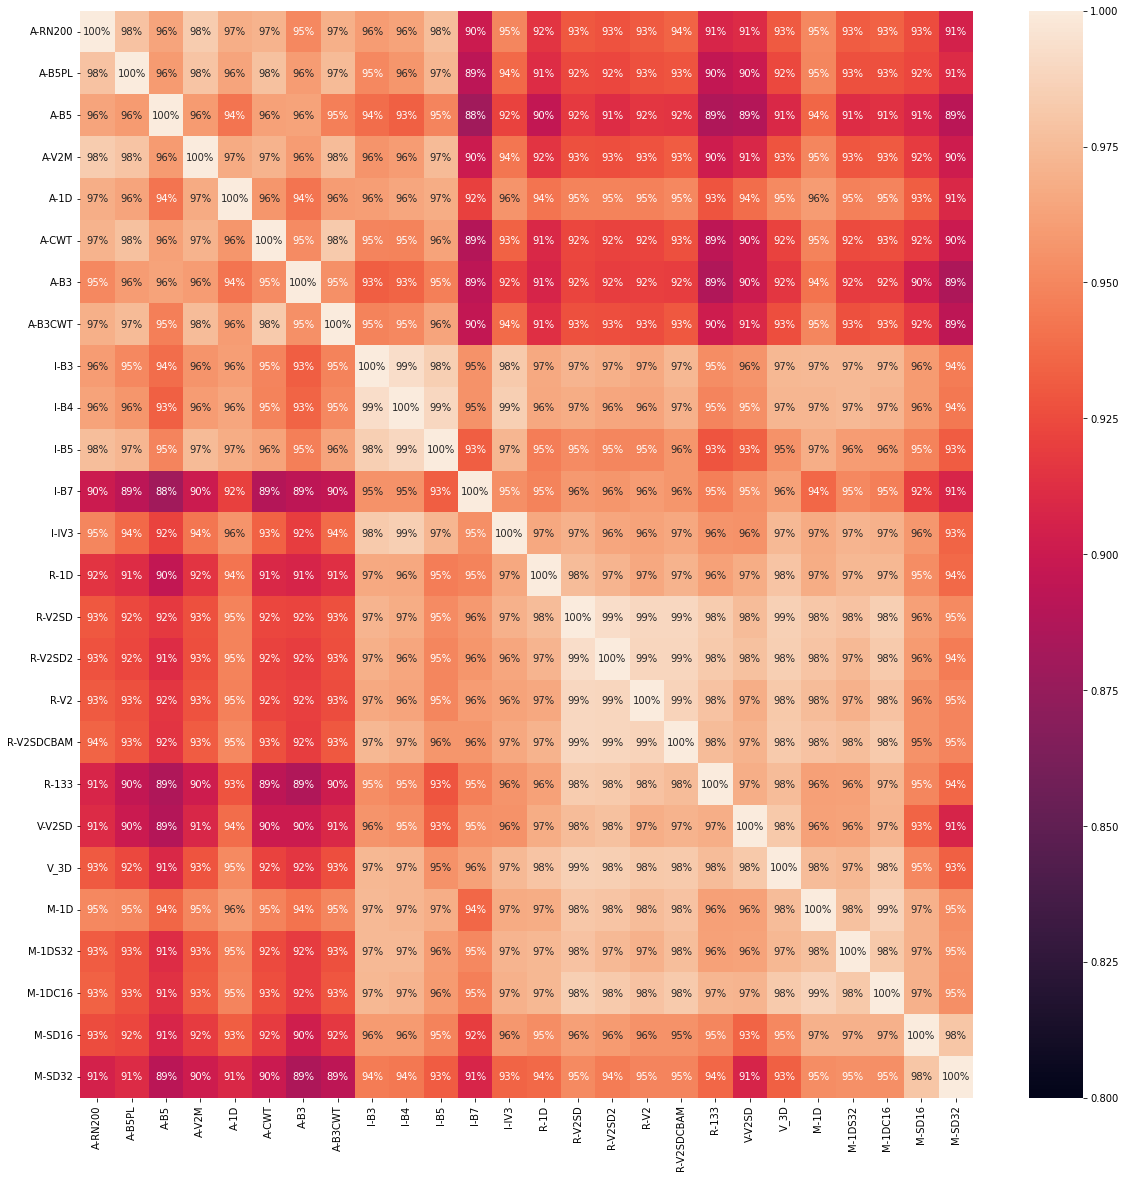

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(oof_df[oof_df.columns[3:]].corr(), vmin=0.8, vmax=1, annot=True, fmt=".0%");
plt.savefig('corr_plot.jpg')

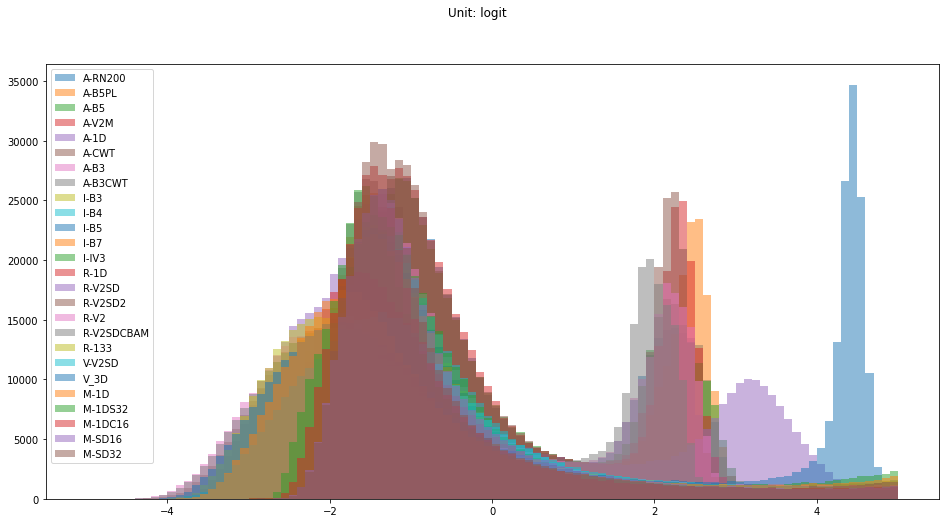

In [17]:
plt.figure(figsize=(16,8))
for o in oof_df.columns[3:]:
    if pre_method == "logit":
        plt.hist(oof_df[o], bins=100, alpha=0.5, range=[-5, 5], label=o)
    else:
        plt.hist(oof_df[o], bins=100, alpha=0.5, label=o)
plt.suptitle(f"Unit: {pre_method}")
plt.legend(loc='upper left');

In [18]:
sum_preds = oof_df.copy()
sum_preds["prediction"] = 0

for col in oof_df.columns[3:]:
    sum_preds["prediction"] += sum_preds[col]
    
print(score_oof(sum_preds), score_oof(sum_preds,True))

0.882617 0.882552


In [19]:
oof_df.head()

,id,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00000e74ad,1,3,-0.351255,-0.522575,-0.033018,-0.152198,-0.841736,-0.347086,-0.208484,...,-0.812512,-0.291818,-1.069867,-0.573439,-0.515197,-0.571567,-0.524821,-0.679856,-0.720252,-0.852324
1,00001f4945,0,0,-0.803476,-1.338088,-1.106954,-0.725166,-1.709305,-1.180710,-1.225705,...,-2.176175,-2.063539,-2.150055,-2.009871,-2.201949,-2.131643,-1.964104,-2.207232,-2.047532,-2.202510
2,0000661522,0,4,-1.121866,-1.507696,-1.106752,-1.140151,-1.570441,-1.062900,-1.160880,...,-1.650357,-1.435673,-1.459411,-1.398183,-1.905624,-1.360621,-1.935468,-1.610143,-1.664001,-1.391888
3,00007a006a,0,0,-1.295713,-1.526156,-1.164980,-1.197089,-1.090511,-1.212057,-1.370953,...,-2.180891,-2.174495,-1.893612,-1.854038,-2.011975,-1.689168,-1.707402,-1.925180,-1.848757,-2.050015
4,0000a38978,1,4,-0.233715,-0.393928,-0.257395,0.126759,-1.130708,-0.315936,-0.620537,...,-1.118793,-0.828881,-0.999819,-0.894331,-1.097700,-0.923380,-1.048386,-1.204157,-0.622966,-0.169255


# NN

In [20]:
from functools import partial
import torch
from torch import nn
from torch.nn import Module
from torch import Tensor
from torch.utils.data import Dataset
import torch.nn.functional as F

from fastai.vision.all import *
from fastai.torch_core import apply_init
from fastai.optimizer import Adam

In [21]:
class StackData(Dataset):
    def __init__(self, df, fold=None, train=True):
        if fold is not None:
            self.df = df[df.fold == fold].copy() if not train else df[df.fold != fold].copy()
        else: 
            self.df = df.copy()
            
        self.targets = self.df['target'].values
        self.train = train
        self.data = self.df.iloc[:,3:].values.astype(np.float32)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        target = self.targets[idx]
        x = self.data[idx]
        return torch.tensor(x), torch.tensor(target,dtype=torch.float).unsqueeze(0)
    
class SubData(Dataset):
    def __init__(self, sub_df):
        self.data = sub_df.iloc[:,1:].values.astype(np.float32)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return torch.tensor(x)
    
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [22]:
def batchnorm_1d(nf:int):
    "A batchnorm2d layer with `nf` features initialized depending on `norm_type`."
    bn = nn.BatchNorm1d(nf)
    with torch.no_grad():
        bn.bias.fill_(1e-3)
        bn.weight.fill_(1.)
    return bn

class LinearBlock(nn.Module):
    def __init__ (self, in_sz, out_sz, activation=nn.ReLU(inplace=True), ps=None):
        super().__init__()
        if ps is not None:
            self.block = nn.Sequential(nn.Linear(in_sz,out_sz), activation, batchnorm_1d(out_sz), nn.Dropout(ps))
        else:
            self.block = nn.Sequential(nn.Linear(in_sz,out_sz), activation, batchnorm_1d(out_sz))
        apply_init(self.block, nn.init.kaiming_normal_)
        
    def forward(self, x:Tensor) -> Tensor:
        return self.block(x)

class Model(Module):
    def __init__(self,sz,first=128, ps=0.2):
        super().__init__()
        #self.bn0 = batchnorm_1d(sz)
        self.b0 = LinearBlock(sz, first, nn.ReLU(), ps)
        self.b1 = LinearBlock(first, first // 2, nn.ReLU(), ps)
        self.b2 = LinearBlock(first // 2, first // 4, nn.ReLU(), ps)
        self.out = nn.Linear(first + first // 2 + first // 4,1)
        apply_init(self.out, nn.init.kaiming_normal_)
        
    def forward(self, x) -> Tensor:
        x0 = self.b0(x)
        x1 = self.b1(x0)
        x2 = self.b2(x1)
        return self.out(torch.cat([x0,x1,x2], dim=-1))

In [23]:
class AUC(Metric):
    def __init__(self, beta=1):
        super().__init__()
        self.preds = []
        self.targets = []
        
    def reset(self): 
        self.preds = []
        self.targets = []
        
    def accumulate(self,learn):
        self.preds.append(learn.pred.cpu())
        self.targets.append(learn.y.cpu())
    
    @property
    def value(self):
        p = torch.cat(self.preds,0)
        t = torch.cat(self.targets,0)
        return roc_auc_score((t > 0).long(), p)

In [24]:
#TF 16 ext
bs = 1024
first=128
fname = 'model1'
preds, targets = [], []
for fold in range(5):
    print("Fold:",fold)
    ds_t = StackData(oof_df,fold=fold,train=True)
    ds_v = StackData(oof_df,fold=fold,train=False)
    data = ImageDataLoaders.from_dsets(ds_t, ds_v, bs=bs,num_workers=2,pin_memory=True).cuda()
    model = Model(sz=oof_df.shape[1]-3, first=first, ps=None)
    model.cuda()
    learn = Learner(data, model, loss_func=F.binary_cross_entropy_with_logits,
                metrics=[AUC()],opt_func=Adam,
                cbs=[GradientClip(),SaveModelCallback(monitor='auc',comp=np.greater)],
                )

    learn.fit_one_cycle(16, lr_max=1e-3)
    torch.save(learn.model.state_dict(),f'./{fname}_{fold}.pth')   
    p = learn.get_preds()
    preds.append(p[0])
    targets.append(p[1])
    
preds,targets = torch.cat(preds),torch.cat(targets)
print(roc_auc_score(targets,preds))

Fold: 0


epoch,train_loss,valid_loss,auc,time
0,0.397373,0.392878,0.881882,00:19
1,0.389001,0.388377,0.883254,00:20
2,0.387408,0.389415,0.883397,00:20
3,0.387094,0.387625,0.883301,00:19
4,0.390385,0.387483,0.883464,00:20
5,0.389972,0.388232,0.883265,00:19
6,0.390301,0.388125,0.883446,00:19
7,0.389988,0.387515,0.883442,00:19
8,0.385092,0.387428,0.883492,00:19
9,0.387133,0.387452,0.883465,00:19


Better model found at epoch 0 with auc value: 0.8818824632809192.
Better model found at epoch 1 with auc value: 0.8832542178309397.
Better model found at epoch 2 with auc value: 0.883397133337321.
Better model found at epoch 4 with auc value: 0.8834635081820305.
Better model found at epoch 8 with auc value: 0.8834922251799988.
Better model found at epoch 10 with auc value: 0.8834927154542641.
Better model found at epoch 11 with auc value: 0.8835118468330108.


Fold: 1


epoch,train_loss,valid_loss,auc,time
0,0.399553,0.397848,0.879914,00:20
1,0.387804,0.391078,0.881831,00:20
2,0.387401,0.391380,0.882128,00:19
3,0.387236,0.390818,0.882183,00:20
4,0.388748,0.389643,0.882420,00:19
5,0.387971,0.390355,0.882346,00:20
6,0.386851,0.389001,0.882409,00:20
7,0.387541,0.389902,0.882484,00:19
8,0.386774,0.389506,0.882487,00:19
9,0.384689,0.389273,0.882449,00:19


Better model found at epoch 0 with auc value: 0.8799137318122103.
Better model found at epoch 1 with auc value: 0.8818313645851236.
Better model found at epoch 2 with auc value: 0.8821278507324805.
Better model found at epoch 3 with auc value: 0.8821830554553185.
Better model found at epoch 4 with auc value: 0.8824199759101772.
Better model found at epoch 7 with auc value: 0.8824841276999008.
Better model found at epoch 8 with auc value: 0.8824865382548984.
Better model found at epoch 11 with auc value: 0.8825130167323187.


Fold: 2


epoch,train_loss,valid_loss,auc,time
0,0.395731,0.395795,0.880829,00:20
1,0.389143,0.389818,0.881559,00:19
2,0.386782,0.389172,0.882107,00:20
3,0.391017,0.388682,0.882159,00:20
4,0.386435,0.390346,0.882162,00:19
5,0.387886,0.388760,0.882215,00:20
6,0.388901,0.390621,0.882180,00:19
7,0.388374,0.388561,0.882176,00:20
8,0.386893,0.390858,0.882245,00:19
9,0.385752,0.388700,0.882228,00:19


Better model found at epoch 0 with auc value: 0.8808293838145915.
Better model found at epoch 1 with auc value: 0.8815585332542961.
Better model found at epoch 2 with auc value: 0.8821065310564031.
Better model found at epoch 3 with auc value: 0.8821588207599262.
Better model found at epoch 4 with auc value: 0.8821618279348592.
Better model found at epoch 5 with auc value: 0.8822150567328289.
Better model found at epoch 8 with auc value: 0.8822454354018193.
Better model found at epoch 10 with auc value: 0.8822489476788246.


Fold: 3


epoch,train_loss,valid_loss,auc,time
0,0.396594,0.393709,0.881706,00:19
1,0.390454,0.388004,0.883358,00:20
2,0.388651,0.388724,0.883705,00:19
3,0.389705,0.386621,0.883993,00:19
4,0.391191,0.387497,0.883861,00:20
5,0.389467,0.386358,0.884023,00:19
6,0.389461,0.386642,0.883775,00:19
7,0.388178,0.386247,0.884014,00:19
8,0.389753,0.386159,0.884064,00:19
9,0.388031,0.386097,0.884144,00:19


Better model found at epoch 0 with auc value: 0.8817055265670546.
Better model found at epoch 1 with auc value: 0.8833576307838316.
Better model found at epoch 2 with auc value: 0.8837045058055112.
Better model found at epoch 3 with auc value: 0.8839925091717258.
Better model found at epoch 5 with auc value: 0.88402333761753.
Better model found at epoch 8 with auc value: 0.8840639557642014.
Better model found at epoch 9 with auc value: 0.8841444559286713.


Fold: 4


epoch,train_loss,valid_loss,auc,time
0,0.395573,0.392878,0.881143,00:20
1,0.389091,0.390113,0.882314,00:19
2,0.385594,0.390438,0.882521,00:20
3,0.386678,0.391615,0.882536,00:19
4,0.386368,0.388004,0.882700,00:19
5,0.387846,0.389751,0.882655,00:20
6,0.387198,0.387669,0.882701,00:19
7,0.391309,0.389501,0.882473,00:20
8,0.387158,0.388629,0.882688,00:19
9,0.389539,0.387566,0.882689,00:19


Better model found at epoch 0 with auc value: 0.8811432090893077.
Better model found at epoch 1 with auc value: 0.8823136833333808.
Better model found at epoch 2 with auc value: 0.8825206320070293.
Better model found at epoch 3 with auc value: 0.8825360942210059.
Better model found at epoch 4 with auc value: 0.882700183357537.
Better model found at epoch 6 with auc value: 0.8827007358129286.
Better model found at epoch 11 with auc value: 0.8827274709867935.
Better model found at epoch 13 with auc value: 0.8827336707639668.


0.8827861919024532


In [25]:
NN_oof_df = []
for fold in range(5):
    oof_df_sub = oof_df.query(f"fold=={fold}")[['id','target','fold']].copy()
    NN_oof_df.append(oof_df_sub)
NN_oof_df = pd.concat(NN_oof_df)
NN_oof_df.reset_index(inplace=True, drop=True)

In [26]:
NN_oof_df["prediction"] = preds.numpy().flatten()
NN_oof_df.groupby("fold").apply(lambda df: roc_auc_score(df['target'], df['prediction']))

fold
0    0.883512
1    0.882513
2    0.882249
3    0.884144
4    0.882734
dtype: float64

In [27]:
CV_SCORE = NN_oof_df.groupby("fold").apply(lambda df: roc_auc_score(df['target'], df['prediction'])).mean()
CV_SCORE

0.8830303875873584

In [28]:
sub_df.head()

,id,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,I-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00005bced6,2.101307,2.408690,2.269970,2.290631,3.007926,2.265291,2.288800,2.101119,6.645071,...,8.281509,10.179740,10.461261,8.698271,9.784908,7.690368,8.372208,8.108096,7.266735,6.764755
1,0000806717,1.514980,1.710782,1.526297,1.593227,1.630305,1.380817,1.237861,0.926948,2.236049,...,2.381183,3.096509,2.282804,2.306015,2.982333,3.117015,3.316813,2.972558,2.936981,2.503957
2,0000ef4fe1,-0.669418,-0.838041,-0.598816,-0.475593,-0.898371,-0.664295,-0.820795,-1.002344,-1.210053,...,-1.191781,-1.126612,-1.157095,-0.820264,-1.268452,-1.090086,-1.033847,-1.032787,-0.854202,-0.906109
3,00020de251,1.280244,1.573700,1.490624,1.264398,1.089086,1.525732,0.952786,1.033834,1.161296,...,2.703779,3.846267,2.557530,1.763387,2.292048,3.289280,3.855694,3.166481,3.382045,2.969906
4,00024887b5,-1.376278,-1.757232,-1.403377,-1.430901,-2.033942,-1.442704,-1.653411,-1.793073,-1.672093,...,-2.881195,-2.932078,-2.730306,-2.351549,-2.672027,-2.485825,-2.609794,-2.480671,-2.203929,-2.352710


In [29]:
from tqdm import tqdm
sub_data = SubData(sub_df)
sub_loader = DataLoader(sub_data, 
                        batch_size=2048, 
                        shuffle=False, 
                        num_workers=2, pin_memory=True, drop_last=False)

nn_sub_df = sub_df[['id']].copy()
for fold in tqdm(range(5)):
    model = Model(sz=oof_df.shape[1]-3, ps=None)
    model.load_state_dict(torch.load(f'./{fname}_{fold}.pth'))
    model.cuda()
    preds = []
    for step, X in enumerate(sub_loader, 1):
        with torch.no_grad():
            X = X.cuda()
            outputs = model(X).squeeze()
            preds.append(outputs.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    nn_sub_df[f"test_{fold}"] = predictions

100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


In [30]:
nn_sub_df

,id,test_0,test_1,test_2,test_3,test_4
0,00005bced6,0.999661,0.999749,0.999705,0.999776,0.999755
1,0000806717,0.950069,0.947042,0.959539,0.963349,0.958712
2,0000ef4fe1,0.313756,0.310307,0.309422,0.312804,0.317754
3,00020de251,0.978593,0.985283,0.979142,0.985862,0.979979
4,00024887b5,0.117679,0.124016,0.119435,0.117777,0.123327
...,...,...,...,...,...,...
225995,ffff4125f1,0.302554,0.310241,0.317144,0.307523,0.310759
225996,ffff9d32a6,0.332113,0.328442,0.317035,0.325748,0.314524
225997,ffff9f4c1f,0.295894,0.283701,0.275502,0.275733,0.272199
225998,ffffa19693,0.999906,0.999924,0.999847,0.999881,0.999885


In [31]:
nn_sub_df["target"] = nn_sub_df[[f"test_{i}" for i in range(5)]].mean(axis=1)

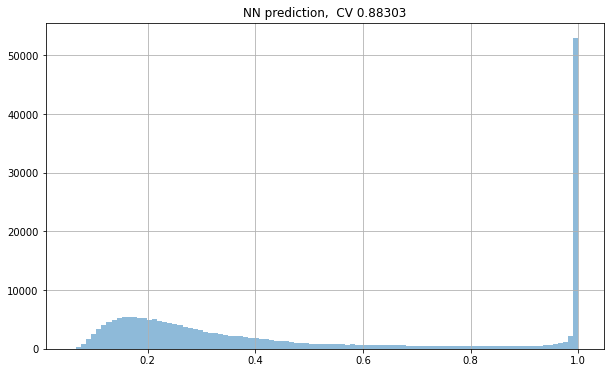

In [32]:
nn_sub_df[["target"]].hist(bins=100,alpha=0.5,figsize=(10,6))
plt.title(f"NN prediction,  CV {CV_SCORE:.5f}");
plt.show()

In [33]:
nn_sub_df[["id","target"]].to_csv(f"NN_sub_CV{CV_SCORE:.5f}.csv",index=False)

# RandomForest

In [34]:
import optuna
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [35]:
def objective(trial:optuna.trial.Trial):
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    rf_max_depth  = trial.suggest_int('rf_max_depth', 3, 8)
    rf_max_features = trial.suggest_uniform('rf_max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('rf_max_samples', 0.6, 0.99)

    clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                 max_depth=rf_max_depth,
                                 max_features=rf_max_features, 
                                 min_samples_split=rf_min_samples_split,
                                 min_samples_leaf=rf_min_samples_leaf, 
                                 max_samples=rf_max_samples,
                                 bootstrap=True, n_jobs=-1, verbose=0, 
                                 random_state=42)        
    aucs = []
    for fold in range(5):
        clf.fit(oof_df.query(f"fold != {fold}").iloc[:,3:], oof_df.query(f"fold!={fold}")['target'])
        X_val = oof_df.query(f"fold == {fold}").iloc[:,3:]
        y_val = oof_df.query(f"fold == {fold}")['target']
        preds = clf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, preds)
        aucs.append(auc)
    return np.mean(aucs)

# study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
# study.optimize(objective, n_trials=20)
# print(study.best_value)
# print(study.best_params)

In [36]:
# study.best_params
# clf = RandomForestClassifier(n_estimators=rf_n_estimators,
#                                  max_depth=rf_max_depth,
#                                  max_features=rf_max_features, 
#                                  min_samples_split=rf_min_samples_split,
#                                  min_samples_leaf=rf_min_samples_leaf, 
#                                  max_samples=rf_max_samples,
#                                  bootstrap=True, n_jobs=-1, verbose=0, 
#                                  random_state=42)        